In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

import vdmlab as vdm

from load_data import get_pos, get_raw_pos, get_events
from maze_functions import spikes_by_position
from plotting_functions import plot_intersects, plot_zone

import sys
sys.path.append('E:\\code\\python-vdmlab\\projects\\emily_shortcut\\info')
import info.R063d2_info as r063d2

In [2]:
# output_path = 'C:\\Users\\Emily\\Code\\emi_shortcut\\cache\\matlab\\spike_pos\\'
output_path = 'E:\\code\\emi_shortcut\\cache\\matlab\\spike_pos\\'
info = r063d2

In [3]:
pos = get_pos(info.pos_mat, info.pxl_to_cm)
raw = get_raw_pos(info.raw_pos_mat, info.pxl_to_cm)
events = get_events(info.event_mat)

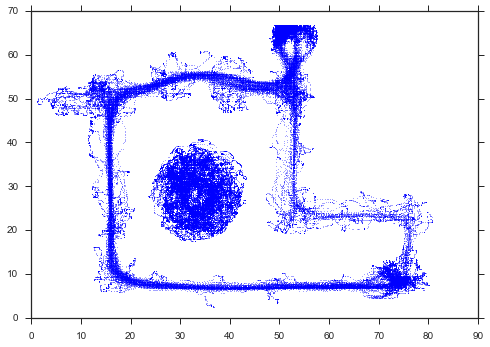

In [4]:
# Plot to check
plt.plot(pos.x, pos.y, 'b.', ms=1)
plt.show()

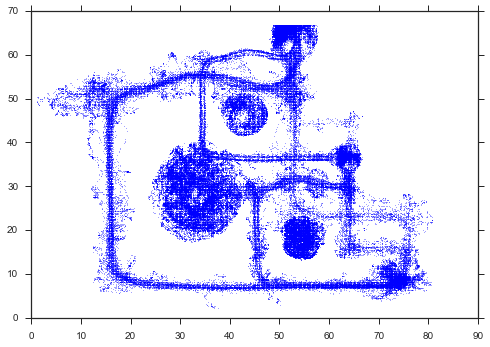

In [5]:
# Plot to check
plt.plot(raw.x, raw.y, 'b.', ms=1)
plt.show()

In [10]:
len(events['led2'])

7

In [11]:
events.keys()

dict_keys(['feeder2', 'led2', 'feederoff', 'label', 'type', 'pb1', 'feeder1', 'ledoff', 'pboff', 'led1', 'pb2'])

In [ ]:
expand_by = 6
feeder1_center = Point(info.path_pts['feeder1'][0], info.path_pts['feeder1'][1])
feeder1 = feeder1_center.buffer(expand_by*2)
feeder2_center = Point(info.path_pts['feeder2'][0], info.path_pts['feeder2'][1])
feeder2 = feeder2_center.buffer(expand_by*2)

In [ ]:
plt.plot(pos.x, pos.y, 'g.', ms=1)
plot_zone(feeder1)
plot_zone(feeder2)
plt.show()